In [1]:
import jax
import jax.numpy as jnp
from networks import MultiLayerPerceptron
import jaxopt
import optax
import time
import numpy as np

2024-10-17 10:32:16.727967: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
d = np.load("data/Tsit.npz")
tt = d["tt"]
u0, uu_ref = d["sol"][0], d["sol"][1:]
yy = uu_ref + 0.1 * np.random.randn(
    *uu_ref.shape
)  # observation = original + gaussian noise (10%)

In [3]:
def lorenz96(u0):
    N = u0.size
    index = jnp.arange(N)
    n_1 = jnp.mod(index + 1, N)
    n__2 = jnp.mod(index - 2, N)
    n__1 = jnp.mod(index - 1, N)
    return (u0[n_1] - u0[n__2]) * u0[n__1] - u0 + 8


def euler_step(u0, dt=0.01):
    return u0 + dt * lorenz96(u0)


def euler_pred(net, u0, y, dt=0.01):
    u_b = u0 + dt * lorenz96(u0)
    u_p = u_b + dt * net(jnp.hstack([u0, y]))
    return u_p, jnp.stack([u_b, u_p])


def unroll(net, u0, yy):
    _, out = jax.lax.scan(lambda u0, y: euler_pred(net, u0, y), u0, yy)
    return out[:, 0], out[:, 1]  # u_b, u_p


def compute_loss(net, u0, yy):
    u_b, u_p = unroll(net, u0, yy)
    loss = ((u_p - u_b) ** 2).mean() + 100 * ((u_p - yy) ** 2).mean()
    return loss

In [4]:
net = MultiLayerPerceptron(d_in=128 * 2, width=192, depth=2, d_out=128)

nIter = 10000
lr = optax.cosine_decay_schedule(1e-4, nIter)
opt = optax.lion(lr)
solver = jaxopt.OptaxSolver(compute_loss, opt, maxiter=nIter, verbose=True)

print("solver running...")
tic = time.time()
model, state = solver.run(net, uu_ref[0, :], yy[:100])
toc = time.time()
print(f"elapsed time: {toc - tic:.2f}")

solver running...
INFO: jaxopt.OptaxSolver: Iter: 1 Gradient Norm (stop. crit.): 14443.7431640625 Objective Value:2707.396484375 
INFO: jaxopt.OptaxSolver: Iter: 2 Gradient Norm (stop. crit.): 17060.796875 Objective Value:2463.07275390625 
INFO: jaxopt.OptaxSolver: Iter: 3 Gradient Norm (stop. crit.): 18319.607421875 Objective Value:2216.529052734375 
INFO: jaxopt.OptaxSolver: Iter: 4 Gradient Norm (stop. crit.): 22221.41796875 Objective Value:1959.129638671875 
INFO: jaxopt.OptaxSolver: Iter: 5 Gradient Norm (stop. crit.): 17785.814453125 Objective Value:1704.575927734375 
INFO: jaxopt.OptaxSolver: Iter: 6 Gradient Norm (stop. crit.): 22340.703125 Objective Value:1550.560302734375 
INFO: jaxopt.OptaxSolver: Iter: 7 Gradient Norm (stop. crit.): 25879.37890625 Objective Value:1434.5130615234375 
INFO: jaxopt.OptaxSolver: Iter: 8 Gradient Norm (stop. crit.): 28053.220703125 Objective Value:1336.109375 
INFO: jaxopt.OptaxSolver: Iter: 9 Gradient Norm (stop. crit.): 28036.517578125 Objecti

In [5]:
uu_b, uu_p = unroll(net, u0, yy[:100])

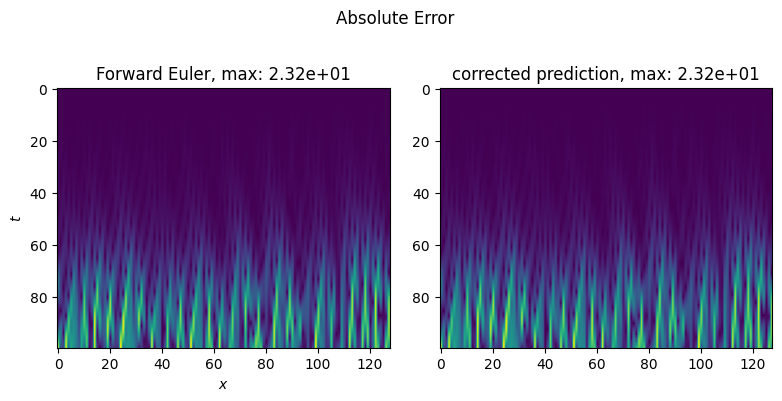

In [6]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
err0 = abs(uu_ref[:100] - uu_b)
err1 = abs(uu_ref[:100] - uu_p)
vmax, vmin = (np.stack([err0, err1])).max(), (np.stack([err0, err1])).min()
ax0.imshow(err0, vmax=vmax, vmin=vmin)
ax0.set_xlabel(r"$x$")
ax0.set_ylabel(r"$t$")
ax0.set_title(f"Forward Euler, max: {err0.max():.2e}")
im = ax1.imshow(err1)
ax1.set_title(f"corrected prediction, max: {err1.max():.2e}")
plt.suptitle("Absolute Error")
plt.tight_layout()
